<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/Final_v1/CNN_model_selecting/mobilenet_v2/mobilenet_v2(all_diseases).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import json
import os

In [6]:
import numpy as np

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
import tensorflow_hub as hub

# loading data set

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train'

In [10]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train')

In [11]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="both",
    seed=123,
    shuffle=True,
    batch_size=32,
    image_size=(224, 224),
    )

Found 7326 files belonging to 4 classes.
Using 5129 files for training.
Using 2197 files for validation.


In [12]:
for batch in train_ds.take(1):
    images, labels = batch
    print(images.shape)  # Should be (32, 224, 224, 3) if batch size is 32
    print(labels.shape)

(32, 224, 224, 3)
(32,)


In [13]:
class_names = train_ds.class_names
class_names

['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

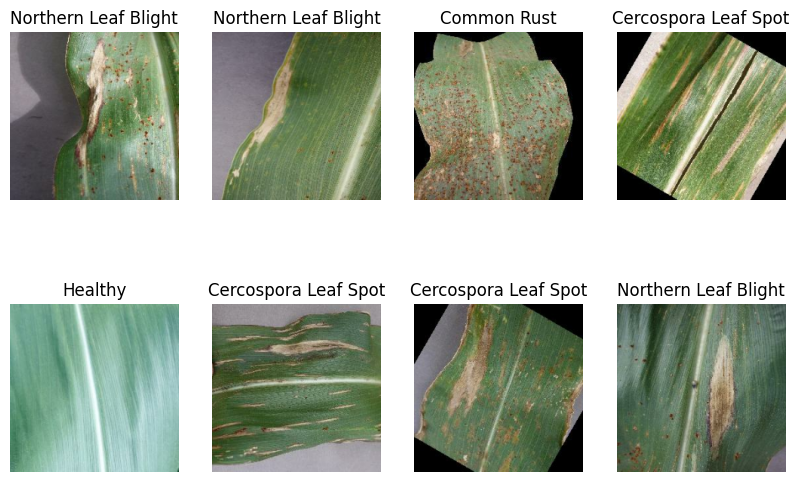

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [15]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 69


In [16]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [17]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 34


# parameters and augmentations

In [18]:
resize_and_rescale = keras.Sequential([
  keras.layers.Resizing(224, 224),
  keras.layers.Rescaling(1./127.5, offset=-1),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [20]:
no_of_classes = len(class_names)
no_of_classes

4

In [21]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [22]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [23]:
epochs = 150

# Loading base model

In [27]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [28]:
base_model.trainable = False

In [29]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# model

In [39]:
def create_model():
  inputs = tf.keras.Input(shape=input_shape)
  x = resize_and_rescale(inputs)
  x = data_augmentation(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = layers.Dense(no_of_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

## Early stopping

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    mode='min',
                                                    patience=5,
                                                    restore_best_weights=True
                                                    )

# Training, Save and evaluation functions

In [41]:
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Final_v1/CNN_model_selecting/mobilenet_v2/models'

In [42]:
model = create_model()
history = model.fit(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_dataset,
                    verbose=1,
                    epochs=epochs,
                    callbacks=[early_stopping]
                    )

model.save(os.path.join(model_path, f'mobilenet_v2_model.keras'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [43]:
test_loss, test_acc = model.evaluate(test_dataset)

34/34 [==============================] - 4s 103ms/step - loss: 0.1019 - accuracy: 0.9642


In [44]:
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.9641544222831726
Test loss: 0.10192573070526123


# loading model(if needed)

In [45]:
#model = create_model()

In [46]:
#model = tf.keras.models.load_model(os.path.join(model_path, f'mobilenet_v2_model.keras.keras'))

# predictions

In [47]:
model.evaluate(test_dataset)

34/34 [==============================] - 4s 103ms/step - loss: 0.1019 - accuracy: 0.9642


[0.10192573070526123, 0.9641544222831726]

In [48]:
predictions = model.predict(test_dataset)

34/34 [==============================] - 5s 124ms/step


In [49]:
predictions

array([[9.9403024e-01, 5.3796975e-07, 5.7176327e-05, 5.9119654e-03],
       [1.1085284e-04, 9.9978966e-01, 5.6596569e-08, 9.9444245e-05],
       [2.9122719e-01, 5.9480084e-07, 6.5787171e-09, 7.0877218e-01],
       ...,
       [5.5665190e-05, 6.7158544e-07, 9.9965322e-01, 2.9042622e-04],
       [4.1946424e-03, 9.4149531e-05, 5.1397451e-06, 9.9570614e-01],
       [4.3989028e-04, 9.9950135e-01, 1.6332555e-05, 4.2395386e-05]],
      dtype=float32)

In [50]:
y_pred_classes = np.argmax(predictions, axis=1)
y_pred_classes

array([0, 1, 3, ..., 2, 3, 1])

In [51]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([0, 1, 3, ..., 2, 3, 1], dtype=int32)

In [52]:
import collections
counter = collections.Counter(y_true)
print(counter)

Counter({3: 297, 1: 295, 2: 269, 0: 227})


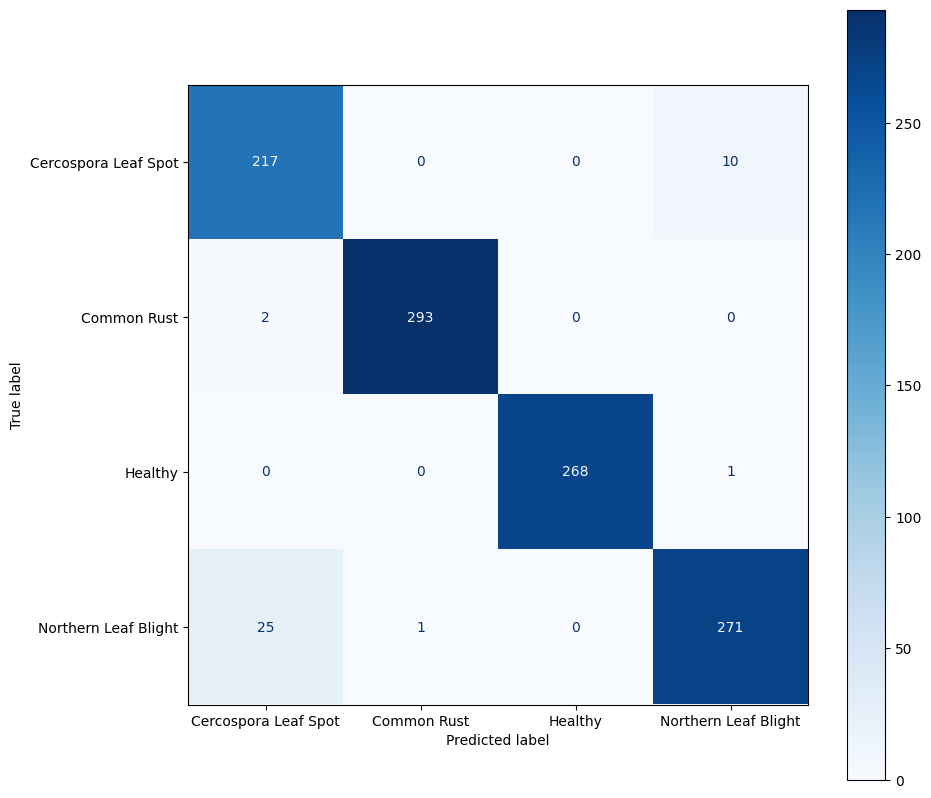

In [53]:
cm = confusion_matrix(y_true, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_names))

                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.89      0.96      0.92       227
         Common Rust       1.00      0.99      0.99       295
             Healthy       1.00      1.00      1.00       269
Northern Leaf Blight       0.96      0.91      0.94       297

            accuracy                           0.96      1088
           macro avg       0.96      0.96      0.96      1088
        weighted avg       0.97      0.96      0.96      1088



# show incorrectly classified images

In [55]:
# Find incorrectly classified images
incorrect_indices = np.where(y_pred_classes != y_true)[0]
incorrect_indices

array([  12,   25,   44,   96,  103,  124,  140,  234,  256,  281,  309,
        310,  382,  392,  399,  417,  426,  480,  521,  526,  607,  635,
        645,  646,  660,  665,  684,  731,  766,  768,  814,  846,  878,
        891,  943,  963,  982,  984, 1046])

In [56]:
# Get the images and labels
images = np.concatenate([x for x, y in test_dataset], axis=0)
incorrect_images = images[incorrect_indices]
incorrect_true_labels = y_true[incorrect_indices]
incorrect_pred_labels = y_pred_classes[incorrect_indices]

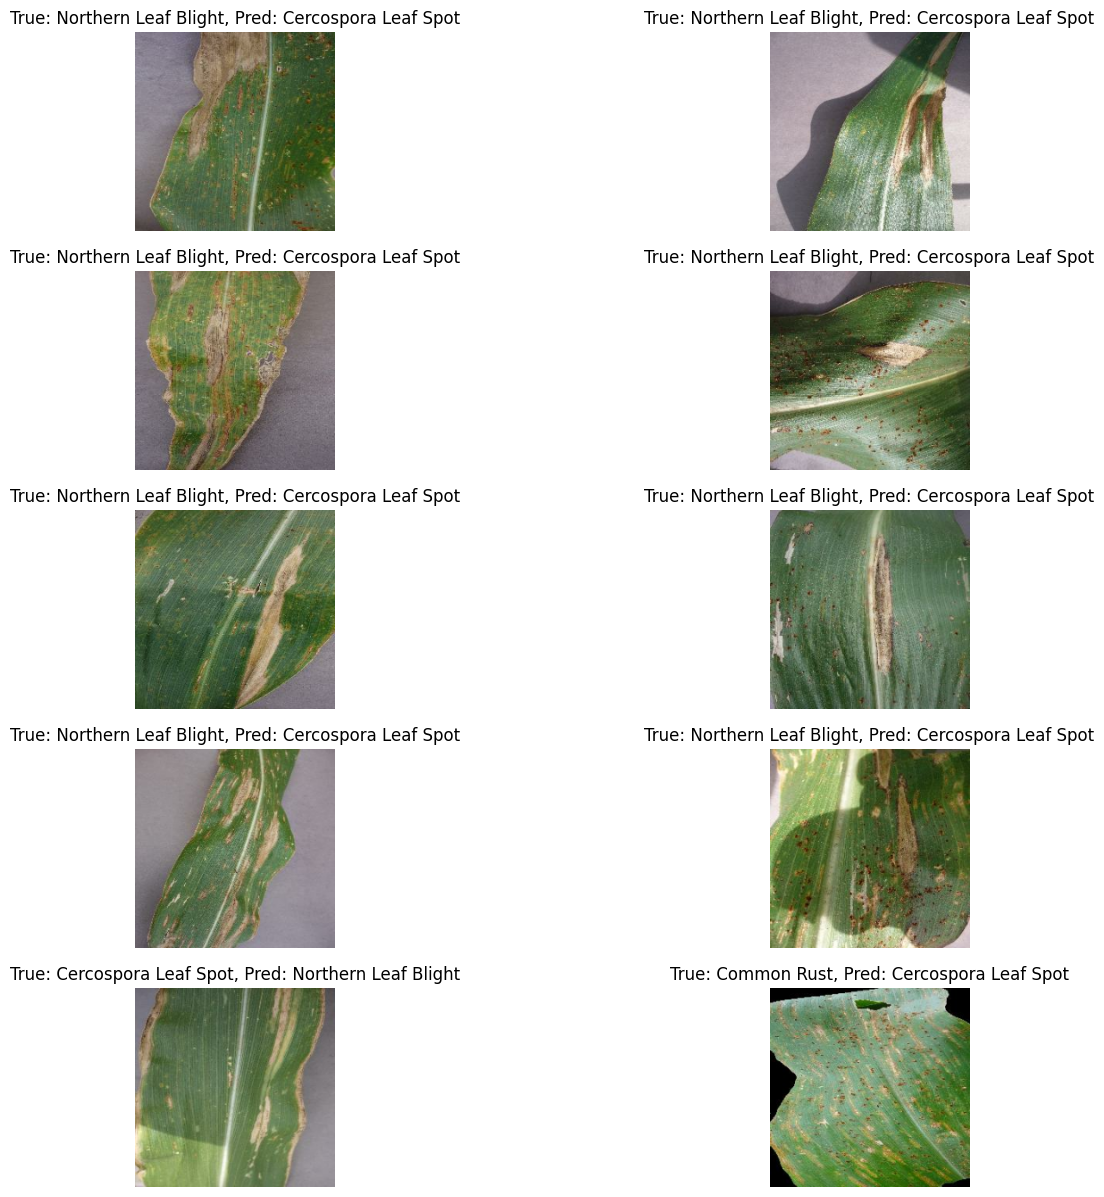

In [57]:
# Display incorrectly classified images
num_images_to_display = 10  # Number of images to display
plt.figure(figsize=(15, 15))
for i in range(min(num_images_to_display, len(incorrect_images))):
    plt.subplot(5, 2, i + 1)
    plt.imshow(incorrect_images[i].astype("uint8"))
    plt.title(f"True: {class_names[incorrect_true_labels[i]]}, Pred: {class_names[incorrect_pred_labels[i]]}")
    plt.axis("off")
plt.show()

leaf spot : Mature lesions from gray leaf spot are rectangular, as they are restricted by the leaf veins.

leaf blight : Northern corn leaf blight is easily identified by the 1- to 6-inch cigar-shaped lesions on lower leaves, which may be grayish-green to tan in color.